**Group H**

•	Saurabh Laltaprasad Gangwar

•	Brayan Leonardo Gil Guevara

•	Rohit Kumar

•	Marzieh Mohammadi Kokaneh

•	Eduardo Roberto Williams Cascante

**Notebook name:** BDM-3035_04_training.ipynb

**Description:** This notebook builds and trains the model

**Version:**

Python 3.11.3

pandas 2.0.3

numpy 1.26.4

matplotlib 3.7.1

tensorflow 2.16.1

In [1]:
%pip install labelme tensorflow tensorflow-gpu opencv-python albumentations
%pip install --upgrade tensorflow

^C
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [18 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "C:\Users\Eduardo\AppData\Local\Temp\pip-install-2tj3h7kb\tensorflow-gpu_f8662a51208f4501baef7ed5cb81b3ea\setup.py", line 37, in <module>
          raise Exception(TF_REMOVAL_WARNING)
      Exception:
      
      The "tensorflow-gpu" package has been removed!
      
      Please install "tensorflow" instead.
      
      Other than the name, the two packages have been identical
      since TensorFlow 2.1, or roughly since Sep 2019. For more
      information, see: pypi.org/project/tensorflow-gpu
      
      
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tensorflow-gpu
ERROR: Could not bu

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached python_version-0.0.2-py2.py3-none-any.whl.metadata (1.7 kB)
Using cached python_version-0.0.2-py2.py3-none-any.whl (3.4 kB)
  Running setup.py clean for tensorflow-gpu
Failed to build tensorflow-gpu


In [1]:
import pandas as pd
import numpy  as np
import os
import cv2
import json
from matplotlib import pyplot as plt

# Importing layers and base network
import tensorflow as tf
from tensorflow.keras.models       import load_model, Model
from tensorflow.keras.layers       import Input, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [4]:
# defining paths
diraug_train_img = "data_aug/train/images/"
diraug_train_lab = "data_aug/train/labels/"
diraug_test_img = "data_aug/test/images/"
diraug_test_lab = "data_aug/test/labels/"
diraug_valid_img = "data_aug/valid/images/"
diraug_valid_lab = "data_aug/valid/labels/"

In [5]:
# defining load_image function

def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [6]:
# defining label loading function

def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
         label = json.load(f)
         
    return [label['class']], label['bbox']

In [7]:
# load train augmented images to tensorflow dataset
train_images = tf.data.Dataset.list_files(diraug_train_img + '*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [8]:
# load test augmented images to tensorflow dataset
test_images = tf.data.Dataset.list_files(diraug_test_img + '*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [9]:
# load valid augmented images to tensorflow dataset
val_images = tf.data.Dataset.list_files(diraug_valid_img + '*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [10]:
# load train labels to Tensorflow Dataset
train_labels = tf.data.Dataset.list_files(diraug_train_lab + '*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [11]:
# load test labels to Tensorflow Dataset
test_labels = tf.data.Dataset.list_files(diraug_test_lab + '*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [12]:
# load valid labels to Tensorflow Dataset
val_labels = tf.data.Dataset.list_files(diraug_valid_lab + '*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [13]:
# check partition lengths
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(8220, 8220, 1680, 1680, 1740, 1740)

In [14]:
# creating final train dataset by conbining labels and images samples
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [15]:
# creating final test dataset by conbining labels and images samples
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [16]:
# creating final validation dataset by conbining labels and images samples
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [17]:
# verifying train dataset
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [2]], dtype=uint8),
 array([[0.2401 , 0.1088 , 0.6855 , 0.6343 ],
        [0.2181 , 0.1539 , 0.8525 , 0.8496 ],
        [0.2542 , 0.0891 , 0.6787 , 0.576  ],
        [0.1545 , 0.04745, 0.621  , 0.5405 ],
        [0.364  , 0.353  , 0.842  , 0.902  ],
        [0.3386 , 0.4653 , 0.724  , 0.831  ],
        [0.3674 , 0.3948 , 0.8013 , 0.896  ],
        [0.5195 , 0.4255 , 0.8564 , 0.888  ]], dtype=float16))

In [18]:
train.as_numpy_iterator().next()[0].shape

(8, 120, 120, 3)

In [19]:
# 7.3 view images and annotations
data_samples = train.as_numpy_iterator()

In [20]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


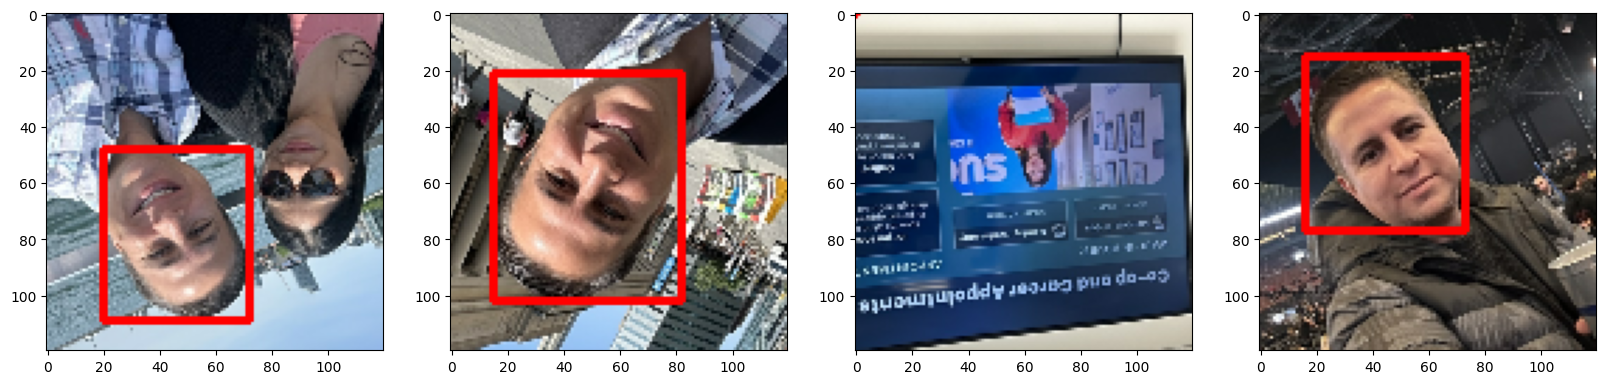

In [21]:
# drawing a sample
fig, ax = plt.subplots(ncols = 4, figsize = (20,20))

for idx in range(4):
    sample_image = res[0][idx].copy()
    sample_coord = res[1][1][idx]

    cv2.rectangle(sample_image,
                  tuple(np.multiply(sample_coord[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coord[2:], [120,120]).astype(int)),
                  (255,0,0), 2)
     
    #ax[idx].set_title(str(res[1][2][idx]))
    ax[idx].imshow(sample_image)

In [22]:
# 8. Building a deep learning using the functional API
# 8.2 Download VGG16
vgg = VGG16(include_top=False)

In [23]:
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# Build instance of Network 
def build_model():
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)
    
    # classification model
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(3, activation='softmax')(class1)
    
    # regression model / bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation = 'relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    
    return facetracker

In [25]:
# 8.4 test out Neural Network
facetracker = build_model()

In [26]:
facetracker.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 120, 120,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 3, 3, 512) │ 14,714,688 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 3)         │      6,147 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 4)         │      8,196 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,830,279 (64.20 MB)

 Trainable params: 16,830,279 (64.20 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
X, y = train.as_numpy_iterator().next()

In [28]:
classes, coords = facetracker.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


In [29]:
classes, coords

(array([[0.6073362 , 0.27708814, 0.11557567],
        [0.43868288, 0.42113203, 0.14018507],
        [0.57381237, 0.26052463, 0.16566305],
        [0.5419144 , 0.3448667 , 0.11321895],
        [0.43868288, 0.42113203, 0.14018507],
        [0.510984  , 0.39094055, 0.09807538],
        [0.35862118, 0.49704096, 0.14433786],
        [0.56125605, 0.3370372 , 0.10170673]], dtype=float32),
 array([[0.5288039 , 0.40422457, 0.2657934 , 0.4155828 ],
        [0.5372761 , 0.31930488, 0.33019495, 0.49723366],
        [0.43138418, 0.22952387, 0.3462697 , 0.4168717 ],
        [0.4534248 , 0.32692325, 0.34483188, 0.5179542 ],
        [0.5372761 , 0.31930488, 0.33019495, 0.49723366],
        [0.41097048, 0.2957507 , 0.3008853 , 0.45524853],
        [0.44363233, 0.29103488, 0.29706416, 0.38327438],
        [0.43494403, 0.24915431, 0.24807465, 0.47144395]], dtype=float32))

In [30]:
opt = tf.keras.optimizers.Adam(learning_rate = 0.0001)

In [31]:
# Creating localization loss and classification loss

def localization_loss(y_true, yhat):
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]
    h_pred = yhat[:,3] - yhat[:,1]
    w_pred = yhat[:,2] - yhat[:,0]
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true - h_pred))
    return delta_coord + delta_size

In [32]:
classloss = tf.keras.losses.SparseCategoricalCrossentropy()
regressloss = localization_loss

In [33]:
# Testing out loss metrics
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=4.8303847>

In [34]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=1.1383685>

In [35]:
class FaceTracker(Model):
      def __init__(self, eyetracker, **kwargs):
          super().__init__(**kwargs)
          self.model = eyetracker
          
      def compile(self, opt, classloss, localizationloss, **kwargs):
          super().compile(**kwargs)
          self.closs = classloss
          self.lloss = localizationloss
          self.opt = opt
          
      @tf.function  # Decorate train_step with @tf.function
      def train_step(self, batch, **kwargs):
          X, y = batch
          
          with tf.GradientTape() as tape:
               try:
                  classes, coords = self.model(X, training=True)
                   
                  # Ensure y[0] has a defined rank (handle potential reshaping)
                  y_0 = tf.reshape(y[0], [-1, 1])  # Example: Reshape to (batch_size, 1) if needed
                  
                  # Check your data format and reshape accordingly
                  # Ensure classes has a defined rank (check model output shape)
                  # ... (reshape classes if necessary based on your model's output)
                  
                  batch_classloss = self.closs(y_0, classes)
                  batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
                  total_loss = batch_localizationloss + 0.5 * batch_classloss
                  
               except tf.errors.InvalidArgumentError as e:
                  # Handle the case where y[0] might have a batch size of zero (optional)
                  if 'Input tensors must be of size at least 1' in str(e):
                     return {"total_loss": tf.constant(0.0)}  # Dummy loss (optional)
                  else:
                     raise e  # Re-raise other errors
                      
               grad = tape.gradient(total_loss, self.model.trainable_variables)
               self.opt.apply_gradients(zip(grad, self.model.trainable_variables))
               
          return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}
          
      def test_step(self, batch, **kwargs):
          X, y = batch
          classes, coords = self.model(X, training=False)
            
          # Ensure y[0] has a defined rank (handle potential reshaping)
          y_0 = tf.reshape(y[0], [-1, 1])  # Example: Reshape to (batch_size, 1) if needed
          # Check your data format and reshape accordingly
          # Ensure classes has a defined rank (check model output shape)
          # ... (reshape classes if necessary based on your model's output)
          batch_classloss = self.closs(y_0, classes)
          batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
          total_loss = batch_localizationloss + 0.5 * batch_classloss
          return {"total_loss": total_loss, "class_loss": batch_classloss,"regress_loss": batch_localizationloss}
          
      def call(self, X, **kwargs):
          return self.model(X, **kwargs)

In [36]:
model = FaceTracker(facetracker)

In [37]:
model.compile(opt, classloss, regressloss)

In [38]:
# defining log folder
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [39]:
hist = model.fit(train, epochs=1, validation_data=val, callbacks=[tensorboard_callback])

1028/1028 ━━━━━━━━━━━━━━━━━━━━ 1787s 2s/step - class_loss: 0.0866 - regress_loss: 0.1363 - total_loss: 0.1796 - val_class_loss: 0.1957 - val_regress_loss: 0.1365 - val_total_loss: 0.2344


In [40]:
# 10.3 Plot Performance
hist.history

{'class_loss': [0.0007510303985327482],
 'regress_loss': [0.010231394320726395],
 'total_loss': [0.010606909170746803],
 'val_class_loss': [0.19573935866355896],
 'val_regress_loss': [0.13653115928173065],
 'val_total_loss': [0.23440083861351013]}

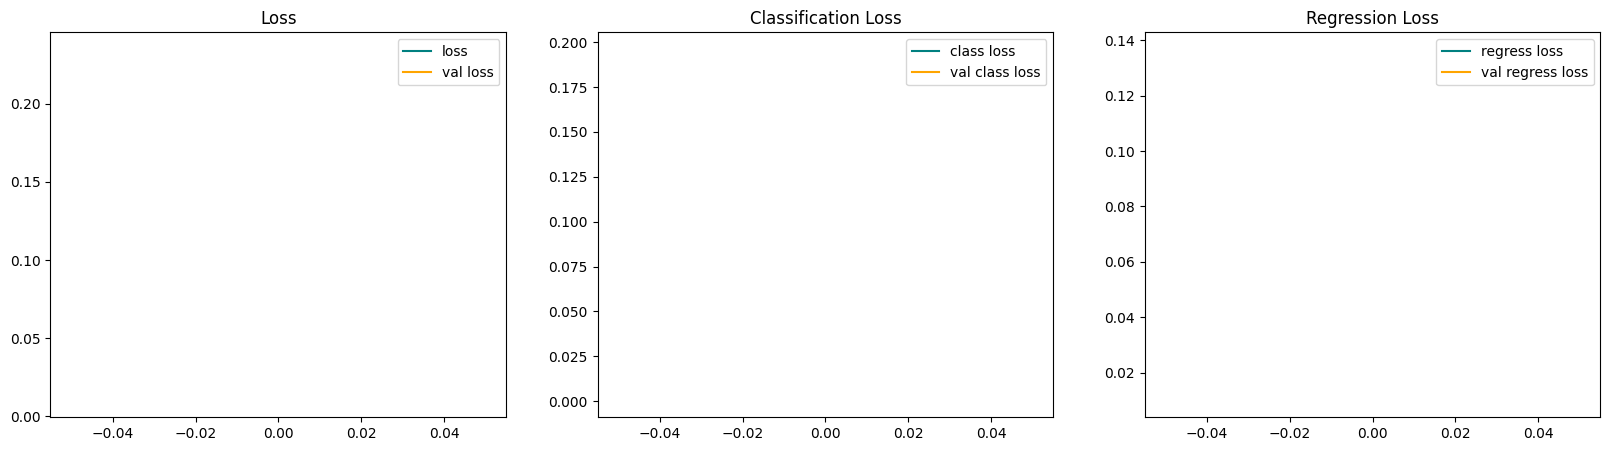

In [41]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

In [42]:
# Making predictions on Test dataset
test_data = test.as_numpy_iterator()

In [43]:
test_sample = test_data.next()

In [44]:
yhat = facetracker.predict(test_sample[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


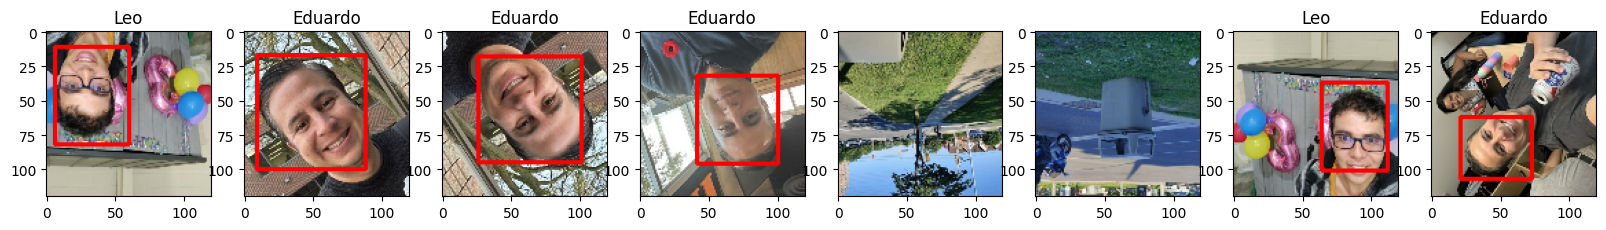

In [45]:
# drawing results
fig, ax = plt.subplots(ncols=8, figsize=(20,20))

for idx in range(8):
    className = ""
    sample_image = test_sample[0][idx].copy()

    classNumber = np.argmax(yhat[0][idx])

    if yhat[0][idx][classNumber] > 0.9:

       if classNumber > 0:
          sample_coord = yhat[1][idx]

          if classNumber == 1:
             className = "Eduardo"
          elif classNumber == 2:
               className = "Leo"

          cv2.rectangle(sample_image,
                        tuple(np.multiply(sample_coord[:2], [120,120]).astype(int)),
                        tuple(np.multiply(sample_coord[2:], [120,120]).astype(int)),
                        (255,0,0), 2)

    ax[idx].set_title(className)
    ax[idx].imshow(sample_image)

In [46]:
#11.2 Save the model
# WARNING:absl:You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`.
# This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or 
# `keras.saving.save_model(model, 'my_model.keras')`.
facetracker.save('facetracker.h5')